<a href="https://colab.research.google.com/github/julialenc/california-housing-prediction/blob/main/monitoring_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
"""
# 📊 Model Monitoring Without External Libraries
## Teaching Data Drift Detection with Basic Python

Author: Your Name
Date: January 2025
"""

# Install only basic libraries
!pip install pandas matplotlib seaborn scipy -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded successfully!")
print(f"📦 Pandas: {pd.__version__}")
print(f"📦 NumPy: {np.__version__}")


✅ Libraries loaded successfully!
📦 Pandas: 2.2.2
📦 NumPy: 2.0.2


In [3]:
# Load California Housing dataset from sklearn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# Fetch data
housing = fetch_california_housing(as_frame=True)
df = housing.frame

# Use 80% as reference (training data)
reference_data, _ = train_test_split(df, test_size=0.2, random_state=42)

print(f"✅ Reference data loaded: {reference_data.shape}")
print(f"\n📊 Columns: {list(reference_data.columns)}")
print(f"\n📈 Summary Statistics:")
print(reference_data.describe())


✅ Reference data loaded: (16512, 9)

📊 Columns: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']

📈 Summary Statistics:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  16512.000000  16512.000000  16512.000000  16512.000000  16512.000000   
mean       3.880754     28.608285      5.435235      1.096685   1426.453004   
std        1.904294     12.602499      2.387375      0.433215   1137.056380   
min        0.499900      1.000000      0.888889      0.333333      3.000000   
25%        2.566700     18.000000      4.452055      1.006508    789.000000   
50%        3.545800     29.000000      5.235874      1.049286   1167.000000   
75%        4.773175     37.000000      6.061037      1.100348   1726.000000   
max       15.000100     52.000000    141.909091     25.636364  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  16512.000000  16512.000000  1651

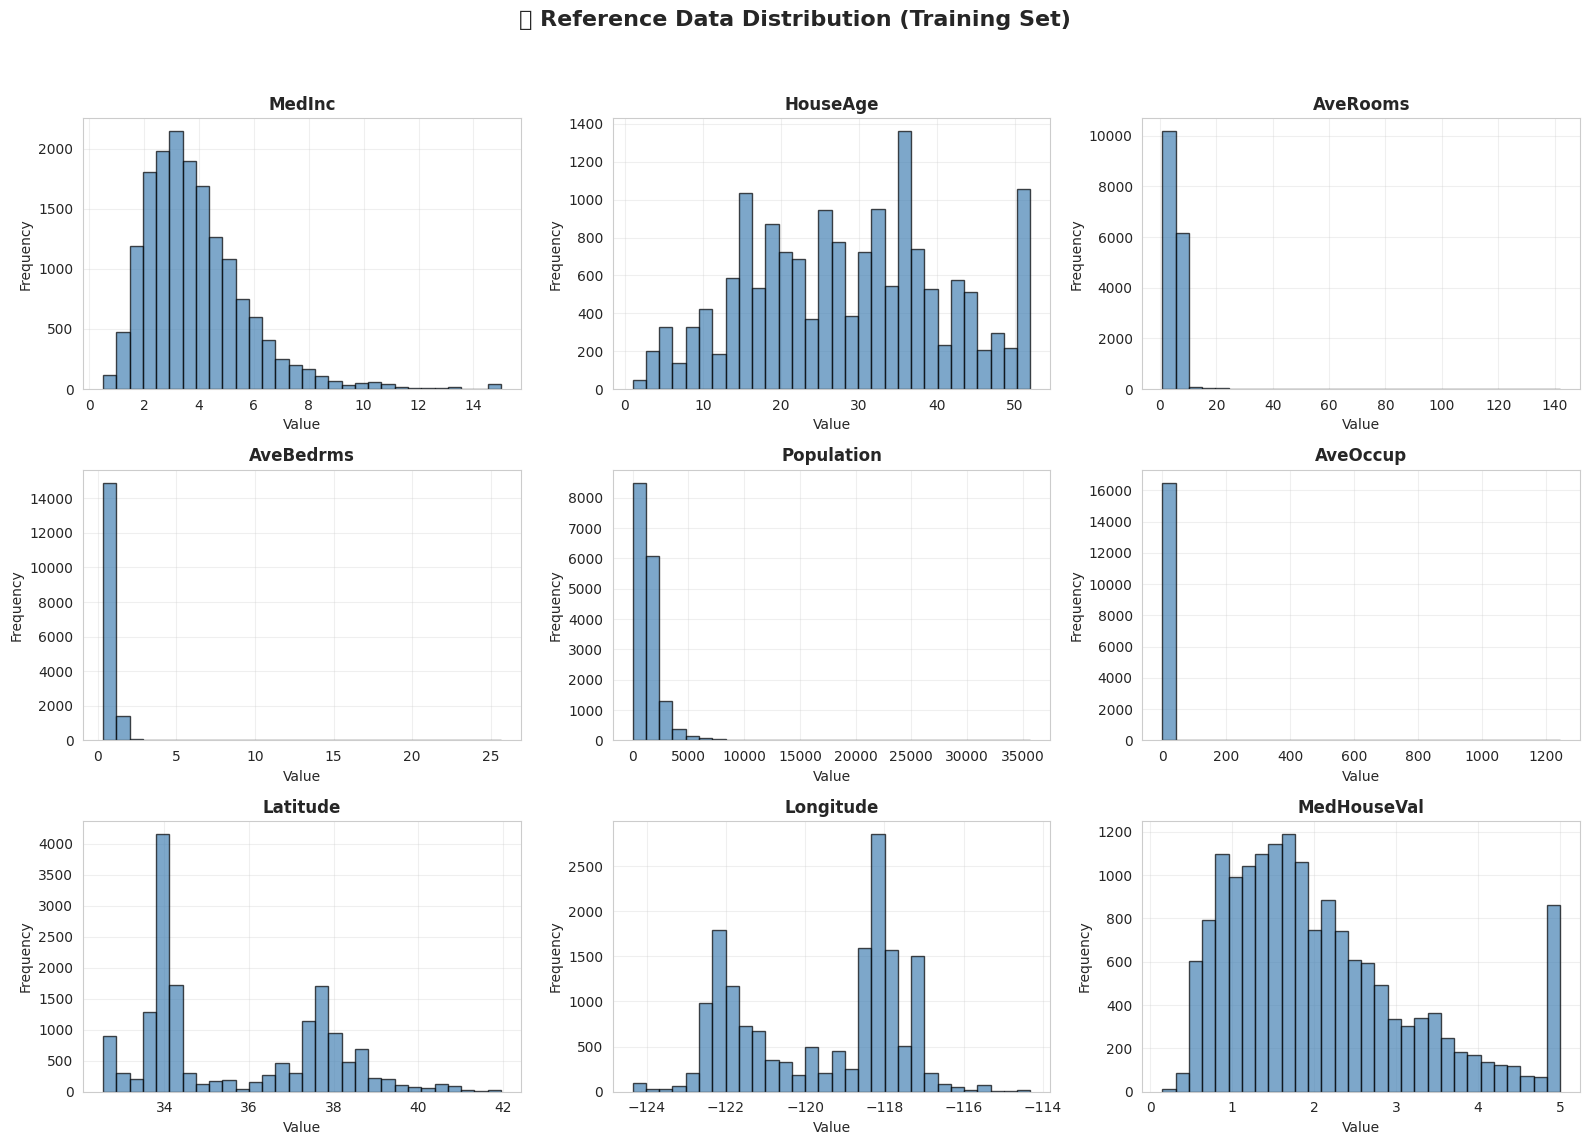

✅ This is what 'normal' looks like for our model!


In [5]:
# Visualize reference data distribution
fig, axes = plt.subplots(3, 3, figsize=(16, 12)) # Changed to 3x3 to accommodate 9 columns
fig.suptitle('📊 Reference Data Distribution (Training Set)', fontsize=16, fontweight='bold')

for idx, col in enumerate(reference_data.columns):
    ax = axes[idx // 3, idx % 3] # Changed indexing to 3 columns per row
    ax.hist(reference_data[col], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_title(col, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjusted layout to prevent title overlap
plt.show()

print("✅ This is what 'normal' looks like for our model!")

In [6]:
# Simulate production data similar to training
np.random.seed(42)
n_samples = 1000

# Sample from reference data
production_week1 = reference_data.sample(n=n_samples, replace=True).copy()

# Add realistic small noise (±3%)
for col in production_week1.columns:
    noise = np.random.normal(0, 0.03, n_samples)
    production_week1[col] = production_week1[col] * (1 + noise)

# Add timestamps
production_week1['timestamp'] = pd.date_range('2024-01-01', periods=n_samples, freq='H')

print(f"✅ Week 1 Production Data: {production_week1.shape}")
print(f"📅 Date Range: {production_week1['timestamp'].min()} to {production_week1['timestamp'].max()}")
print(f"\n💡 This data should look similar to training (no drift expected)")


✅ Week 1 Production Data: (1000, 10)
📅 Date Range: 2024-01-01 00:00:00 to 2024-02-11 15:00:00

💡 This data should look similar to training (no drift expected)


In [7]:
# Simulate drifted data - market changed!
production_month6 = reference_data.sample(n=n_samples, replace=True).copy()

# Introduce significant drift (realistic scenario: housing boom)
production_month6['MedInc'] *= 1.35          # Income increased 35%
production_month6['HouseAge'] += 12          # Houses aged 12 years
production_month6['AveRooms'] *= 1.25        # More rooms (renovations)
production_month6['AveBedrms'] *= 1.15       # More bedrooms
production_month6['Population'] *= 1.20      # Population grew 20%
production_month6['AveOccup'] *= 1.10        # More occupancy
production_month6['Latitude'] += 0.5         # Geographic shift
production_month6['Longitude'] -= 0.5        # Geographic shift
production_month6['MedHouseVal'] *= 1.60     # Prices jumped 60%!

# Add timestamps (6 months later)
production_month6['timestamp'] = pd.date_range('2024-06-01', periods=n_samples, freq='H')

print(f"✅ Month 6 Production Data: {production_month6.shape}")
print(f"📅 Date Range: {production_month6['timestamp'].min()} to {production_month6['timestamp'].max()}")
print(f"\n🚨 Drift Introduced:")
print(f"   - Median Income: +35%")
print(f"   - House Age: +12 years")
print(f"   - Average Rooms: +25%")
print(f"   - Population: +20%")
print(f"   - House Prices: +60%")
print(f"   - Geographic shift in Lat/Long")


✅ Month 6 Production Data: (1000, 10)
📅 Date Range: 2024-06-01 00:00:00 to 2024-07-12 15:00:00

🚨 Drift Introduced:
   - Median Income: +35%
   - House Age: +12 years
   - Average Rooms: +25%
   - Population: +20%
   - House Prices: +60%
   - Geographic shift in Lat/Long


In [8]:
# Kolmogorov-Smirnov test for distribution comparison
def detect_drift(reference, production, feature, threshold=0.05):
    """
    Use KS test to detect if distributions are different

    Returns:
        - statistic: KS test statistic (higher = more different)
        - p_value: probability distributions are same
        - drifted: True if p_value < threshold
    """
    statistic, p_value = stats.ks_2samp(reference[feature], production[feature])
    drifted = p_value < threshold
    return statistic, p_value, drifted

# Test Week 1 (should have minimal drift)
print("="*70)
print("📊 DRIFT DETECTION - WEEK 1 (Expected: No Drift)")
print("="*70)

week1_results = []
for col in reference_data.columns:
    stat, p_val, drifted = detect_drift(reference_data, production_week1, col)
    week1_results.append({
        'Feature': col,
        'KS_Statistic': f'{stat:.4f}',
        'P_Value': f'{p_val:.4f}',
        'Drift?': '🚨 YES' if drifted else '✅ NO'
    })

week1_df = pd.DataFrame(week1_results)
print(week1_df.to_string(index=False))

drift_count_week1 = sum(1 for r in week1_results if '🚨' in r['Drift?'])
print(f"\n📊 Summary: {drift_count_week1}/{len(reference_data.columns)} features show drift")

# Test Month 6 (should have significant drift)
print("\n" + "="*70)
print("📊 DRIFT DETECTION - MONTH 6 (Expected: DRIFT DETECTED)")
print("="*70)

month6_results = []
for col in reference_data.columns:
    stat, p_val, drifted = detect_drift(reference_data, production_month6, col)
    month6_results.append({
        'Feature': col,
        'KS_Statistic': f'{stat:.4f}',
        'P_Value': f'{p_val:.4f}',
        'Drift?': '🚨 YES' if drifted else '✅ NO'
    })

month6_df = pd.DataFrame(month6_results)
print(month6_df.to_string(index=False))

drift_count_month6 = sum(1 for r in month6_results if '🚨' in r['Drift?'])
print(f"\n📊 Summary: {drift_count_month6}/{len(reference_data.columns)} features show drift")
print(f"\n{'🚨 CRITICAL DRIFT!' if drift_count_month6 > 4 else '✅ Acceptable'}")


📊 DRIFT DETECTION - WEEK 1 (Expected: No Drift)
    Feature KS_Statistic P_Value Drift?
     MedInc       0.0260  0.5380   ✅ NO
   HouseAge       0.0376  0.1346   ✅ NO
   AveRooms       0.0268  0.4969   ✅ NO
  AveBedrms       0.0445  0.0466  🚨 YES
 Population       0.0279  0.4478   ✅ NO
   AveOccup       0.0305  0.3363   ✅ NO
   Latitude       0.1594  0.0000  🚨 YES
  Longitude       0.2327  0.0000  🚨 YES
MedHouseVal       0.0314  0.3044   ✅ NO

📊 Summary: 3/9 features show drift

📊 DRIFT DETECTION - MONTH 6 (Expected: DRIFT DETECTED)
    Feature KS_Statistic P_Value Drift?
     MedInc       0.2652  0.0000  🚨 YES
   HouseAge       0.3616  0.0000  🚨 YES
   AveRooms       0.3813  0.0000  🚨 YES
  AveBedrms       0.6839  0.0000  🚨 YES
 Population       0.1352  0.0000  🚨 YES
   AveOccup       0.1582  0.0000  🚨 YES
   Latitude       0.3744  0.0000  🚨 YES
  Longitude       0.2736  0.0000  🚨 YES
MedHouseVal       0.3482  0.0000  🚨 YES

📊 Summary: 9/9 features show drift

🚨 CRITICAL DRIFT!


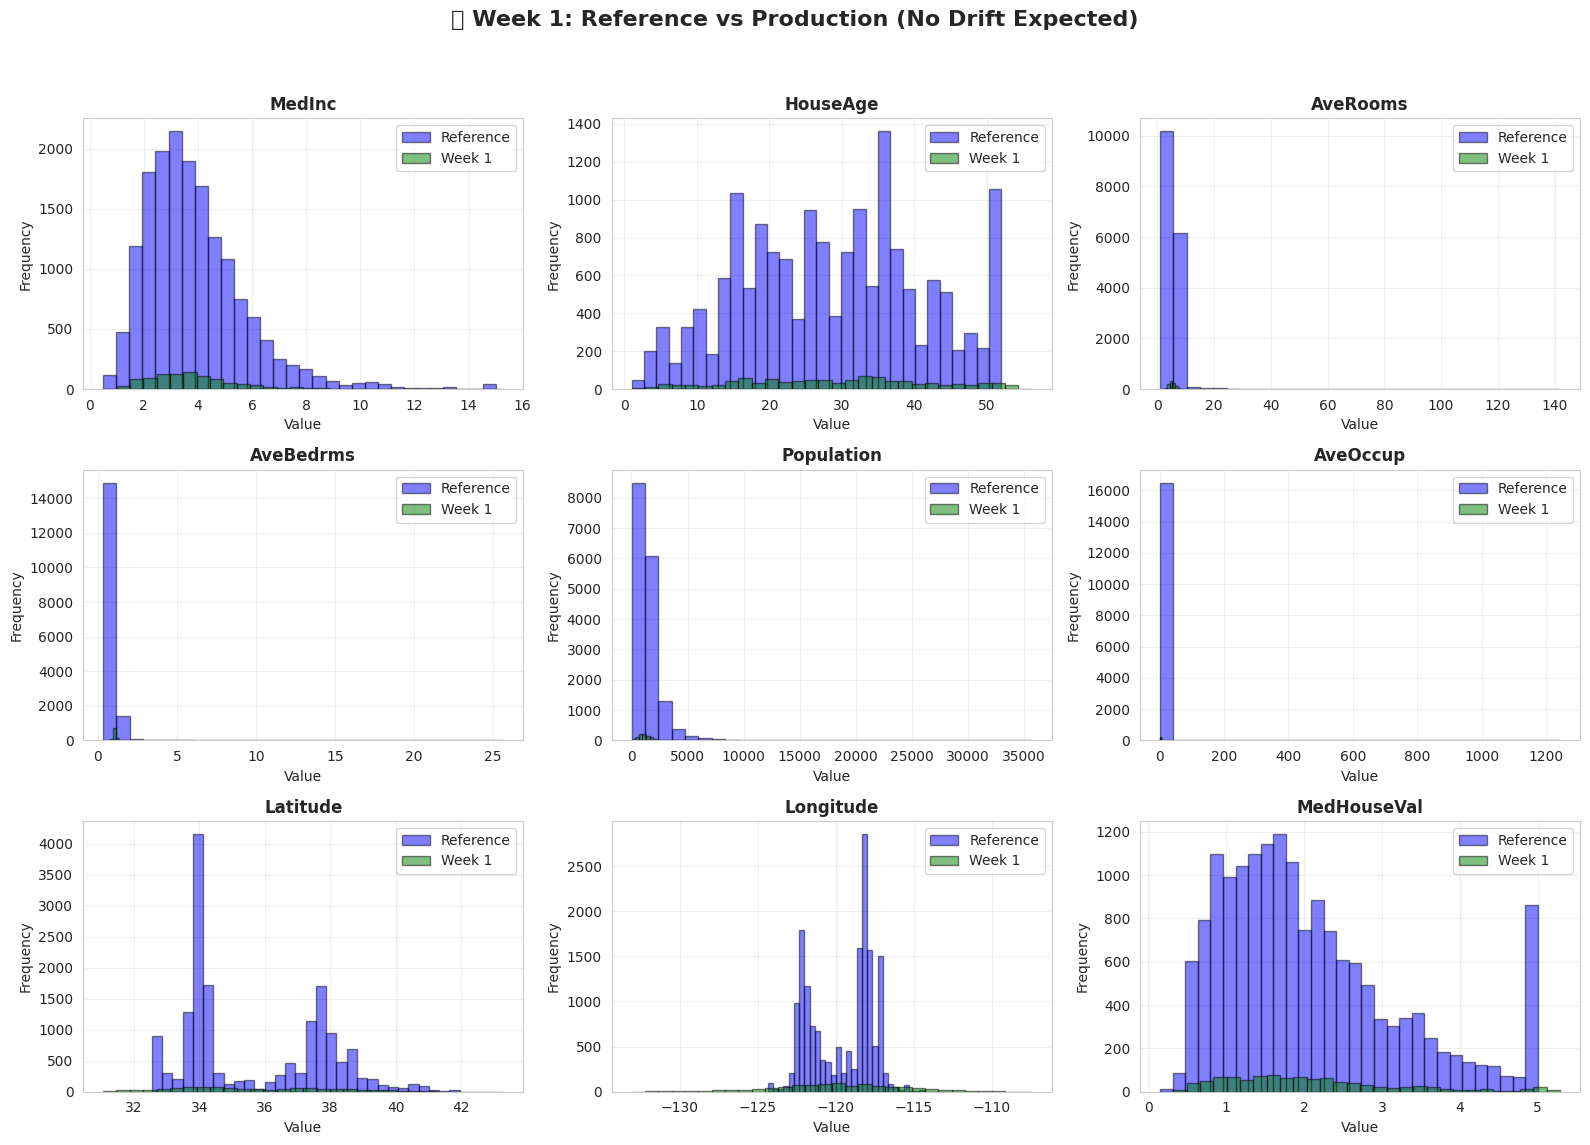

✅ Week 1: Blue and green overlap significantly → No drift!


In [10]:
# Visualize Week 1 distributions
fig, axes = plt.subplots(3, 3, figsize=(16, 12)) # Changed to 3x3 to accommodate 9 columns
fig.suptitle('📊 Week 1: Reference vs Production (No Drift Expected)', fontsize=16, fontweight='bold')

for idx, col in enumerate(reference_data.columns):
    ax = axes[idx // 3, idx % 3] # Changed indexing to 3 columns per row

    # Plot both distributions
    ax.hist(reference_data[col], bins=30, alpha=0.5, label='Reference', color='blue', edgecolor='black')
    ax.hist(production_week1[col], bins=30, alpha=0.5, label='Week 1', color='green', edgecolor='black')

    ax.set_title(col, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjusted layout to prevent title overlap
plt.show()

print("✅ Week 1: Blue and green overlap significantly → No drift!")

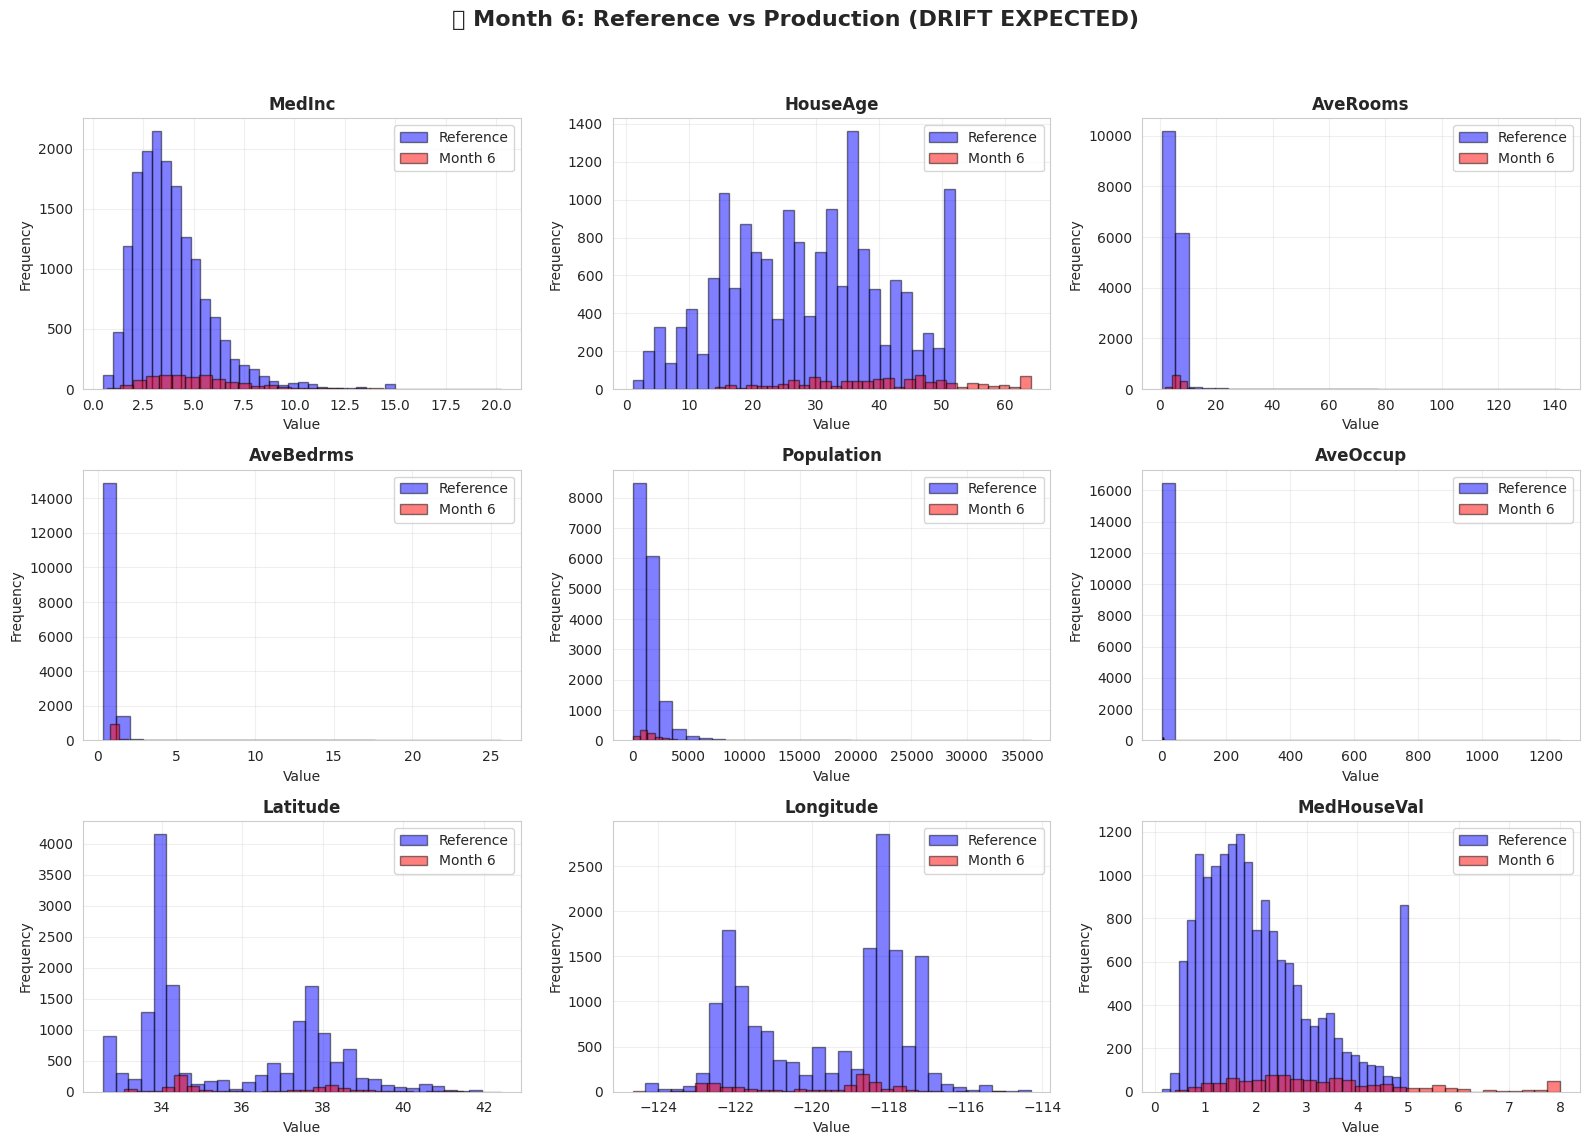

🚨 Month 6: Red shifted from blue → Significant drift!


In [12]:
# Visualize Month 6 distributions
fig, axes = plt.subplots(3, 3, figsize=(16, 12)) # Changed to 3x3 to accommodate 9 columns
fig.suptitle('📊 Month 6: Reference vs Production (DRIFT EXPECTED)', fontsize=16, fontweight='bold')

for idx, col in enumerate(reference_data.columns):
    ax = axes[idx // 3, idx % 3] # Changed indexing to 3 columns per row

    # Plot both distributions
    ax.hist(reference_data[col], bins=30, alpha=0.5, label='Reference', color='blue', edgecolor='black')
    ax.hist(production_month6[col], bins=30, alpha=0.5, label='Month 6', color='red', edgecolor='black')

    ax.set_title(col, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjusted layout to prevent title overlap
plt.show()

print("🚨 Month 6: Red shifted from blue → Significant drift!")

In [13]:
# Detailed numerical comparison
print("="*70)
print("📊 MEAN VALUE COMPARISON")
print("="*70)

comparison = pd.DataFrame({
    'Reference': reference_data.mean(),
    'Week_1': production_week1.drop('timestamp', axis=1).mean(),
    'Month_6': production_month6.drop('timestamp', axis=1).mean()
})

comparison['Week1_Change_%'] = ((comparison['Week_1'] - comparison['Reference']) / comparison['Reference'] * 100)
comparison['Month6_Change_%'] = ((comparison['Month_6'] - comparison['Reference']) / comparison['Reference'] * 100)

print(comparison.round(2))

print("\n" + "="*70)
print("⚠️  FEATURES WITH >10% CHANGE (Month 6):")
print("="*70)

large_changes = comparison[comparison['Month6_Change_%'].abs() > 10]
for feature in large_changes.index:
    change = large_changes.loc[feature, 'Month6_Change_%']
    print(f"   • {feature}: {change:+.1f}%")


📊 MEAN VALUE COMPARISON
             Reference   Week_1  Month_6  Week1_Change_%  Month6_Change_%
MedInc            3.88     3.86     5.24           -0.53            35.13
HouseAge         28.61    29.21    40.74            2.11            42.41
AveRooms          5.44     5.44     6.87            0.06            26.41
AveBedrms         1.10     1.10     1.29            0.13            17.93
Population     1426.45  1432.87  1694.71            0.45            18.81
AveOccup          3.10     2.92     3.20           -5.76             3.46
Latitude         35.64    35.69    36.15            0.12             1.42
Longitude      -119.58  -119.73  -120.10            0.13             0.43
MedHouseVal       2.07     2.07     3.35           -0.06            61.65

⚠️  FEATURES WITH >10% CHANGE (Month 6):
   • MedInc: +35.1%
   • HouseAge: +42.4%
   • AveRooms: +26.4%
   • AveBedrms: +17.9%
   • Population: +18.8%
   • MedHouseVal: +61.7%


In [14]:
# Create simple monitoring decision logic
def monitoring_decision(drift_count, total_features, change_pct_list):
    """Make monitoring decision based on drift metrics"""

    drift_ratio = drift_count / total_features
    max_change = max([abs(x) for x in change_pct_list])

    print("="*70)
    print("🎯 MONITORING DECISION FRAMEWORK")
    print("="*70)

    print(f"\n📊 Metrics:")
    print(f"   - Drifted Features: {drift_count}/{total_features} ({drift_ratio:.1%})")
    print(f"   - Maximum Change: {max_change:.1f}%")

    print(f"\n🚦 Status:")

    if drift_ratio >= 0.5 or max_change > 30:
        print("   🚨 CRITICAL - Immediate Action Required")
        print("\n📋 Actions:")
        print("   1. Stop using current model for critical decisions")
        print("   2. Investigate root cause of drift")
        print("   3. Retrain model with recent data")
        print("   4. Update feature engineering if needed")
        print("   5. Set up automated retraining pipeline")

    elif drift_ratio >= 0.3 or max_change > 15:
        print("   ⚠️  WARNING - Monitor Closely")
        print("\n📋 Actions:")
        print("   1. Increase monitoring frequency")
        print("   2. Collect more recent data for retraining")
        print("   3. Review model performance metrics")
        print("   4. Prepare retraining process")

    else:
        print("   ✅ HEALTHY - Continue Normal Operations")
        print("\n📋 Actions:")
        print("   1. Continue regular monitoring")
        print("   2. Log metrics for trend analysis")
        print("   3. No immediate action needed")

# Apply to Week 1
print("\n" + "🔵 WEEK 1 ANALYSIS".center(70, "="))
week1_changes = comparison['Week1_Change_%'].dropna().tolist()
monitoring_decision(drift_count_week1, len(reference_data.columns), week1_changes)

# Apply to Month 6
print("\n\n" + "🔴 MONTH 6 ANALYSIS".center(70, "="))
month6_changes = comparison['Month6_Change_%'].dropna().tolist()
monitoring_decision(drift_count_month6, len(reference_data.columns), month6_changes)



==========================🔵 WEEK 1 ANALYSIS===========================
🎯 MONITORING DECISION FRAMEWORK

📊 Metrics:
   - Drifted Features: 3/9 (33.3%)
   - Maximum Change: 5.8%

🚦 Status:
   ⚠️  WARNING - Monitor Closely

📋 Actions:
   1. Increase monitoring frequency
   2. Collect more recent data for retraining
   3. Review model performance metrics
   4. Prepare retraining process


==========================🔴 MONTH 6 ANALYSIS==========================
🎯 MONITORING DECISION FRAMEWORK

📊 Metrics:
   - Drifted Features: 9/9 (100.0%)
   - Maximum Change: 61.7%

🚦 Status:
   🚨 CRITICAL - Immediate Action Required

📋 Actions:
   1. Stop using current model for critical decisions
   2. Investigate root cause of drift
   3. Retrain model with recent data
   4. Update feature engineering if needed
   5. Set up automated retraining pipeline
